In [1]:
from numba import njit
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator
from itertools import product
import matplotlib.pyplot as plt

In [2]:
l = 3
beta0 = 0.5 #days^-1
gamma = 0.1 #days^-1
nu = 1/100 #days^-1
# T = 40
p_base_range = (0.1, 0.3)

p_cap = 1e-3
epsilon = 1e-4
s = 0. # seasonal forcing
omega = 2 * np.pi / 360 #days⁻1

maxVax = 0.01 # Von N0 können pro tag geimpft werden

p_vax = 1000 # Anteil der Leute, die angst haben und sich deswegen Impfen lassen wollen
mu_im = 1/14 #1/days

# p_base = np.linspace(p_base_range[0], p_base_range[1], num=l, endpoint=True)



In [3]:
poi = [
(35, 0.35),
(35, 0.30),
(35, 0.14),
(44, 0.322),
(26.8, 0.347),
(70, 0.20),
(70, 0.36)
]

In [4]:
@njit
def P(H, p_base):
    return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))

@njit
def vax(H):
    return (1- np.exp(-p_vax*H))* maxVax

@njit
def Gamma(t):
    return 1#+ s* np.cos(omega*t)

def odes(t, p, T, p_base):
    S = p[:l]
    V = p[l:2*l]
    V1 = p[2*l:3*l]
    I = p[3*l:4*l]
    H_1 = p[4*l:5*l]
    H = p[5*l:6*l]
    R = p[6*l:7*l]
    #R = 1-S-I -V - V1
    
    dS = - beta0 * P(H, p_base) * Gamma(t) * I * S + nu * (R+V) - vax(H) * S
    dV =  V1 * mu_im - nu * V
    dV1 = vax(H) * S - V1 * mu_im - beta0 * P(H, p_base) * Gamma(t) * I * V1 #TODO die hier muessen noch infiziert werden
    
    dI = beta0 * P(H, p_base) * Gamma(t) * I * (S+V1) - gamma * I 
    dR = gamma*I - nu*R
    dH_1 = 2/T * (I - H_1)
    dH = 2/T * (H_1 - H)
    
    return np.concatenate((dS,dV, dV1, dI,dH_1, dH, dR))

@njit
def quedenker_odes(t, p, T, p_base):
    S = p[:l]
    I = p[l:2*l]
    H_1 = p[2*l:3*l]
    H = p[3*l:4*l]
    R = p[4*l:5*l]

    dS = - beta0 * P(H, p_base) * Gamma(t) * I * S + nu * R
    
    dI = beta0 * P(H, p_base) * Gamma(t) * I * (S) - gamma * I 
    dR = gamma*I - nu*R
    dH_1 = 2/T * (I - H_1)
    dH = 2/T * (H_1 - H)
    
    return np.concatenate((dS, dI,dH_1, dH, dR))

In [5]:
I0 = 1e-4 * np.ones(l)
S0 = (1-I0)
H_10 = 0 * np.ones(l)
H0 = 0 * np.ones(l)
V0 = 0. *np.ones(l)
V10=0 *np.ones(l)
R0 = np.zeros(l)
p0 = np.concatenate((S0, V0, V10, I0, H_10, H0, R0))
querdenkerP0 = np.concatenate((S0, I0, H_10, H0, R0))

print(len(p0))

21


In [6]:
maxdt = 1
sol = []
qsol = []
for n,params in enumerate(poi):
    sol1 = solve_ivp(odes, (0,10000), p0, max_step=maxdt, args=params)
    qsol1 = solve_ivp(quedenker_odes, (0,10000), querdenkerP0, max_step=maxdt, args=params)
    sol.append(sol1)
    qsol.append(qsol1)

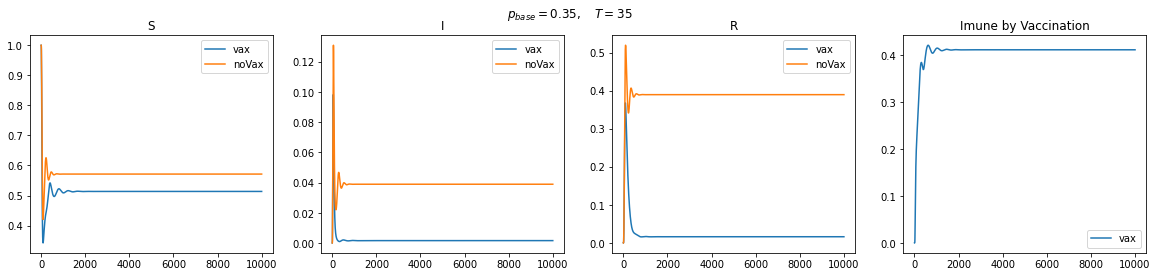

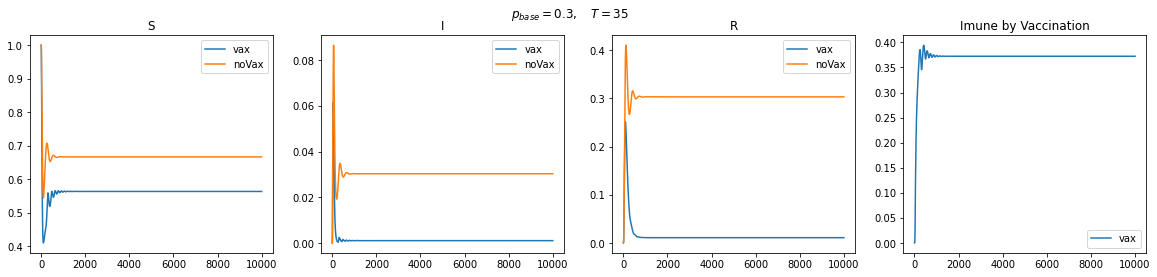

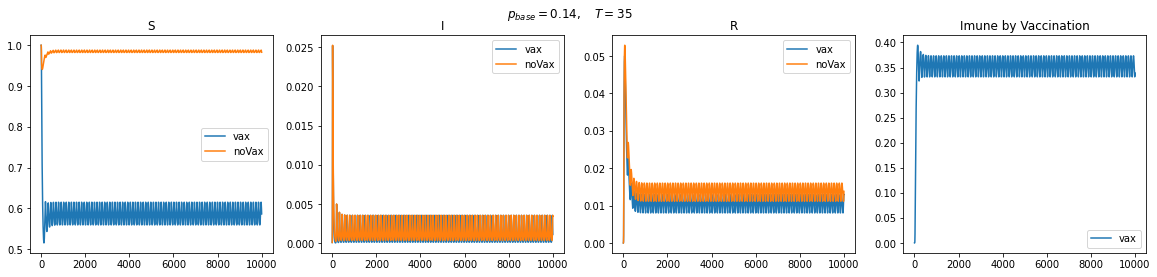

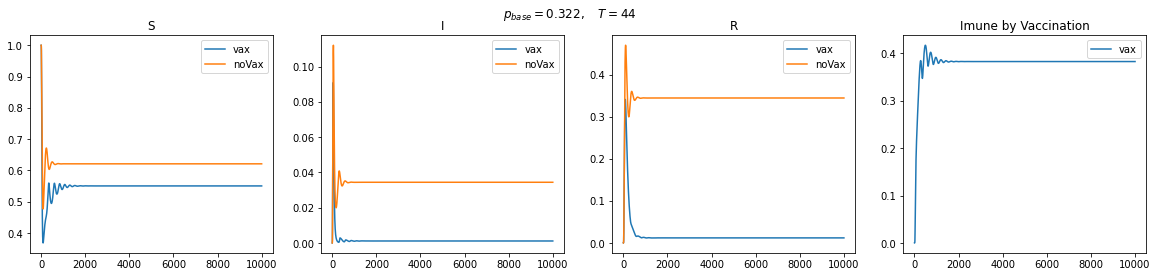

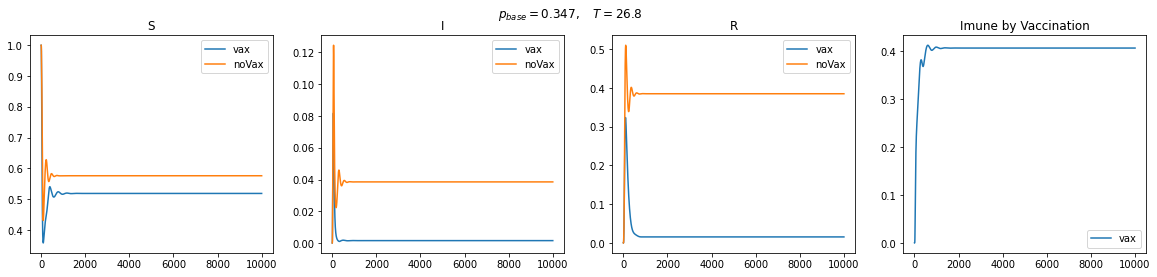

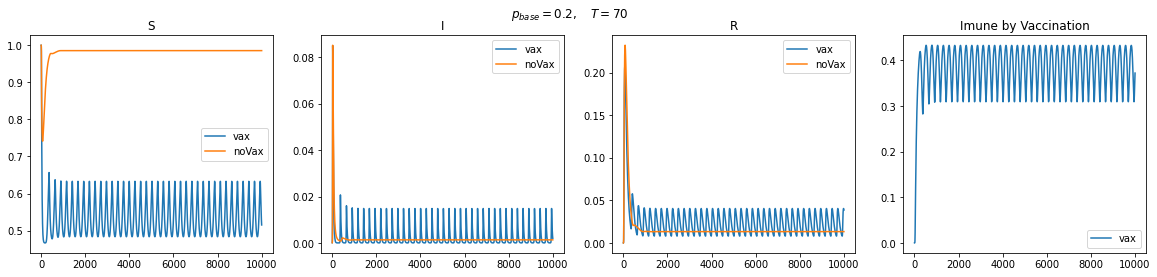

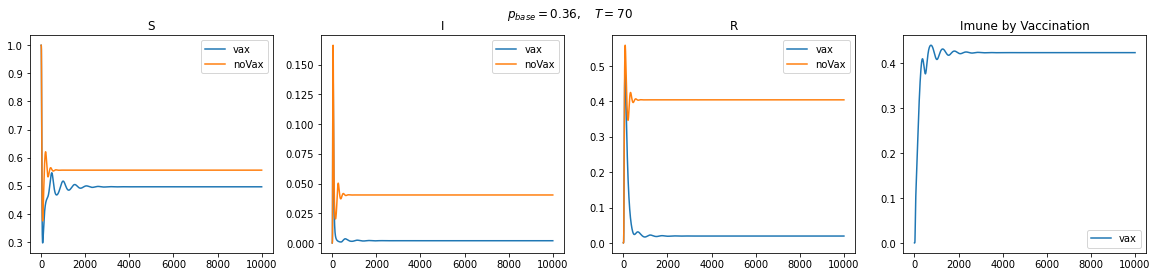

In [7]:
for i,params in enumerate(poi):
    p = sol[i].y
    t = sol[i].t

    S = p[:l]
    V = p[l:2*l]
    V1 = p[2*l:3*l]
    I = p[3*l:4*l]
    H_1 = p[4*l:5*l]
    H = p[5*l:6*l]
    R = p[6*l:7*l]


    qp = qsol[i].y
    qt = qsol[i].t

    qS = qp[:l]
    qI = qp[l:2*l]
    qH_1 = qp[2*l:3*l]
    qH = qp[3*l:4*l]
    qR = qp[4*l:5*l]


    base = 'base'

    # print(S)

    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(f"$p_{{base}}= {params[1]},\quad T = {params[0]}$")
    plt.subplot(1,4,1)
    # plt.ylim(S[0][-1]-1e-11, S[0][-1]+1e-11)
    plt.title("S")
    plt.plot(t, S[0], label="vax")
    plt.plot(t, qS[0], label="noVax")
    plt.legend()
    plt.subplot(1,4,2)
    # plt.ylim(I[0][-1]-1e-11, I[0][-1]+1e-11)
    plt.title("I")
    plt.plot(t, I[0], label="vax")
    plt.plot(t, qI[0], label="noVax")
    plt.legend()
    plt.subplot(1,4,3)
    # plt.ylim(R[0][-1]-1e-11, R[0][-1]+1e-11)
    plt.title("R")
    plt.plot(t, R[0], label="vax")
    plt.plot(t, qR[0], label="noVax")
    plt.legend()
    plt.subplot(1,4,4)
    # plt.ylim(V[0][-1]-1e-11, V[0][-1]+1e-11)
    plt.title("Imune by Vaccination")
    plt.plot(t, V[0], label="vax")
    plt.legend()
    
    # plt.show()
    

    plt.savefig(f"finalplots_pn={params[1]}_T={params[0]}.png")

In [8]:
# qp = qsol[0].y
# qt = qsol[0].t

# qS = qp[:l]
# qI = qp[l:2*l]
# qH_1 = qp[2*l:3*l]
# qH = qp[3*l:4*l]
# qR = qp[4*l:5*l]

In [9]:
# import matplotlib.pyplot as plt
# for i, p_b in enumerate(p_base):
#     fig = plt.figure(figsize=(20, 4))
#     fig.suptitle(f"P_base= {p_b}")
#     plt.subplot(1,4,1)
#     plt.title("S")
#     plt.plot(t, S[i], label="vax")
#     plt.plot(t, qS[i], label="noVax")
#     plt.legend()
#     plt.subplot(1,4,2)
#     plt.title("I")
#     plt.plot(t, I[i], label="vax")
#     plt.plot(t, qI[i], label="noVax")
#     plt.legend()
#     plt.subplot(1,4,3)
#     plt.title("R")
#     plt.plot(t, R[i], label="vax")
#     plt.plot(t, qR[i], label="noVax")
#     plt.legend()
#     plt.subplot(1,4,4)
#     plt.title("Imune by Vaccination")
#     plt.plot(t, V[i], label="vax")
#     plt.legend()
    

#     plt.savefig(f"figuresDay2{i}.png")